In [2]:
from fastprogress.fastprogress import progress_bar

import torch

import matplotlib.pyplot as plt
from jupyterthemes import jtplot

jtplot.style(context="talk")

In [3]:
def plot_regression_data(model=None, MSE=None, poly_deg=0):

    # Plot the noisy scatter points and the "true" function
    plt.scatter(x_train, y_train, label="Noisy Samples")
    plt.plot(x_true, y_true, "--", label="True Function")

    # Plot the model's learned regression function
    if model:
        x = x_true.unsqueeze(-1)
        x = x.pow(torch.arange(poly_deg + 1)) if poly_deg else x

        with torch.no_grad():
            yhat = model(x)

        plt.plot(x_true, yhat, label="Learned Function")

    plt.xlim([min_x, max_x])
    plt.ylim([-5, 5])
    plt.legend()
    if MSE:
        plt.title(f"MSE = ${MSE}$")

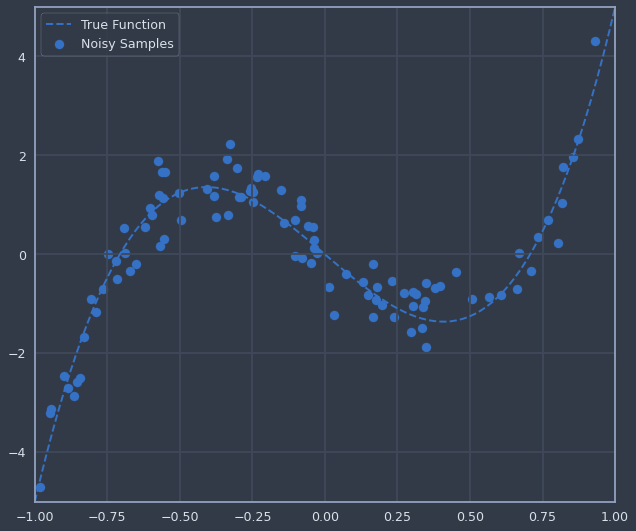

In [39]:
def fake_y(x, add_noise=False):
    y = 10 * x ** 3 - 5 * x
    return y + torch.randn_like(y) * 0.5 if add_noise else y


N = 100

min_x, max_x = -1, 1

x_true = torch.linspace(min_x, max_x, 100)
y_true = fake_y(x_true)

x_train = torch.rand(N) * (max_x - min_x) + min_x
y_train = fake_y(x_train, add_noise=True)

plot_regression_data()

# What are the "pieces" needed to "learn" a line that matches the curve above

- loss (cost) function
- derivatices (some form of adjustment)
- parameters

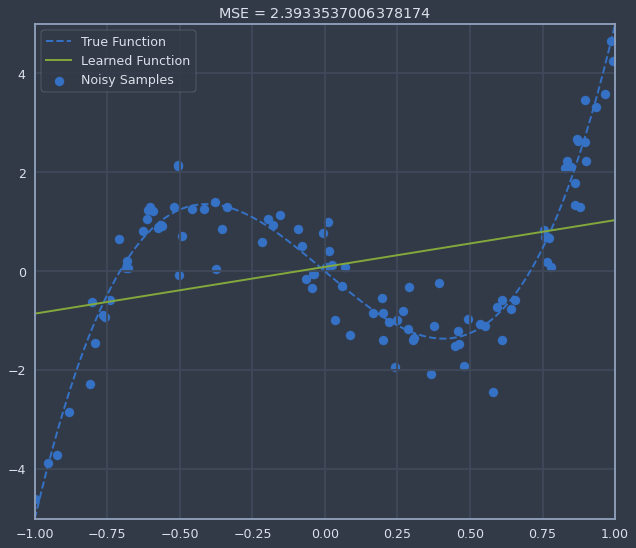

In [15]:
# Hyperparameters
num_epochs = 100
learning_rate = 0.1

# Model parameters
m = torch.randn(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# Torch utils
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD([m, b], lr=learning_rate)

# Train
for epoch in range(num_epochs):
    
    yhat = m * x_train + b
    
    optimizer.zero_grad()
    loss = criterion(yhat, y_train)
    loss.backward()
    optimizer.step()

plot_regression_data(model=lambda x: m * x + b, MSE=loss.item())

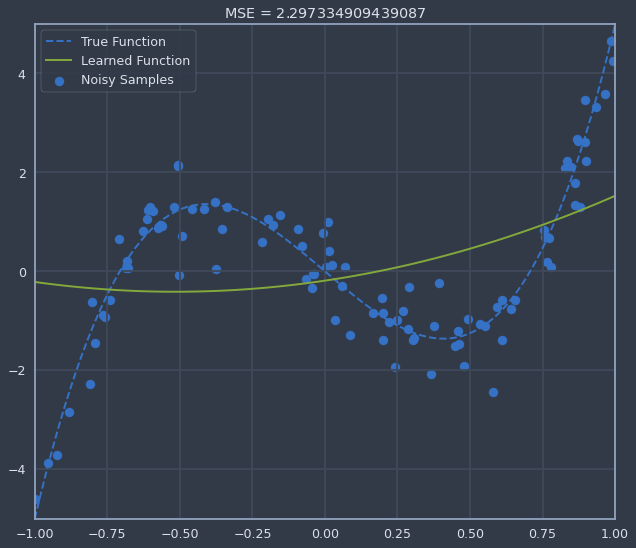

In [16]:
# Hyperparameters
num_epochs = 100
learning_rate = 0.1

# Model parameters
w2 = torch.randn(1, requires_grad=True)
w1 = torch.randn(1, requires_grad=True)
w0 = torch.zeros(1, requires_grad=True)

def model(x):
    return w2 * x * x + w1 * x + w0

# Torch utils
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD([w0, w1, w2], lr=learning_rate)

# Train
for epoch in range(num_epochs):
    
    yhat = model(x_train)
    
    optimizer.zero_grad()
    loss = criterion(yhat, y_train)
    loss.backward()
    optimizer.step()

plot_regression_data(model=model, MSE=loss.item())

$$
y = mx + b
$$

$$
y = w_2 x^2 + w_1 x^1 + w_0
$$

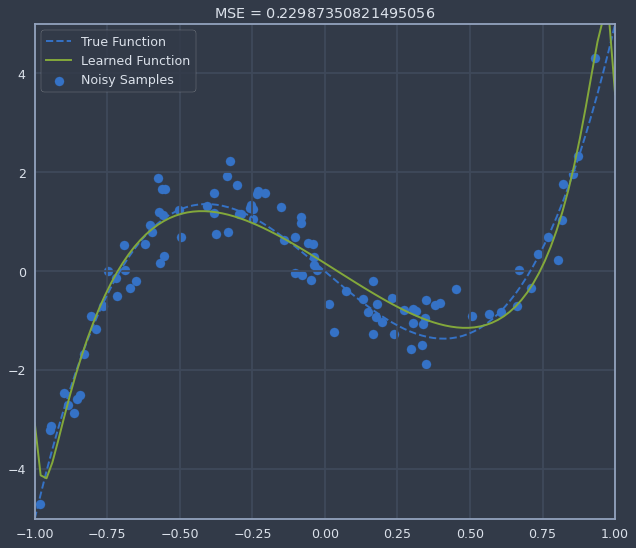

In [42]:
# Hyperparameters
learning_rate = 0.1
num_epochs = 1000

# Model parameters
degrees = 50  # 3, 4, 16, 32, 64, 128
powers = torch.arange(degrees + 1)
x_poly = x_train.unsqueeze(-1).pow(powers)
params = torch.randn(degrees + 1, requires_grad=True)

# Torch utils
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD([params], lr=learning_rate)

# Regression
for epoch in range(num_epochs):
    # Model
    yhat = x_poly @ params

    # Update parameters
    optimizer.zero_grad()
    loss = criterion(yhat, y_train)
    loss.backward()
    optimizer.step()

plot_regression_data(lambda x: x @ params, poly_deg=degrees, MSE=loss.item())

In [43]:
params.round()

tensor([ 0., -4., -1.,  5., -0.,  3.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,
         0.,  0., -0.,  0., -0.,  1.,  1., -1., -1.,  1., -0., -2., -1.,  1.,
        -0.,  0., -1.,  1.,  1., -0.,  1., -2., -1., -0.,  0.,  1., -0., -1.,
         1., -2., -1.,  0., -1., -2., -0.,  0.,  1.], grad_fn=<RoundBackward>)

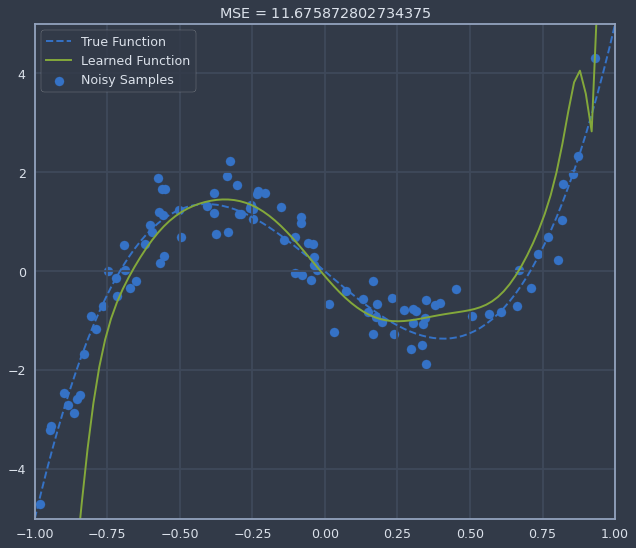

In [44]:
params = ((x_poly.T @ x_poly).inverse() @ x_poly.T) @ y_train
mse = torch.nn.functional.mse_loss(x_poly @ params, y_train)
plot_regression_data(lambda x: x @ params, poly_deg=degrees, MSE=mse)
# params

In [36]:
params

tensor([ 5.4599e-01, -4.6489e+00, -1.3338e+01, -3.7559e+01,  6.8446e+01,
         3.6870e+02, -1.8593e+01, -6.8566e+02, -4.8374e+01, -3.1333e+02,
        -1.2463e+03,  3.8702e+02,  1.8268e+03,  1.0353e+03,  4.8718e+02,
         8.4013e+02, -2.0758e+02, -2.7988e+02,  1.1727e+02, -1.0116e+03,
        -6.4030e+02,  2.9279e+02, -2.8167e+02, -8.3610e+02, -6.4566e+02,
        -7.7850e+02,  5.9883e+02, -1.6572e+02,  9.0489e+02,  7.8002e+02,
        -1.2063e+03, -1.1682e+03, -2.1657e+02,  1.2252e+03, -3.0342e+02,
         6.4590e+01,  1.3374e+03, -2.1492e+02, -5.7293e+02,  6.5306e+02,
        -1.1992e+03, -7.5993e+02, -6.9858e+02,  1.8683e+03,  1.6142e+03,
        -3.4608e+02,  1.4354e+03,  2.9777e+03,  8.7211e+02, -2.4650e+03,
        -3.5130e+03])

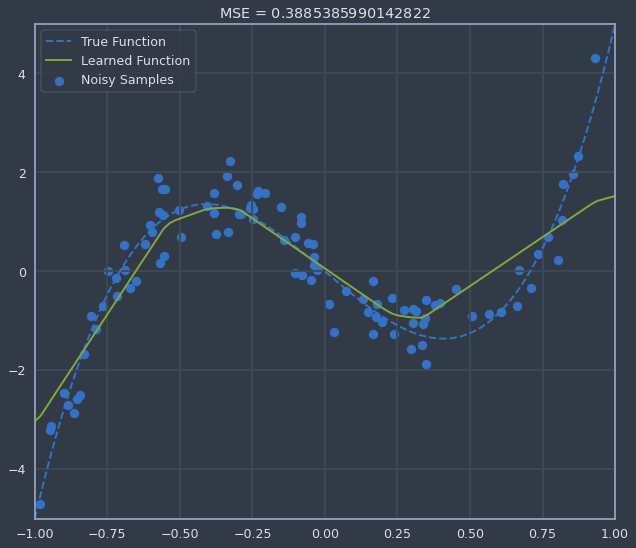

In [46]:
# Hyperparameters
learning_rate = 0.01
num_epochs = 10000
regularization =  1e-1

# Model parameters
model = torch.nn.Sequential(
    torch.nn.Linear(1, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 1),
)

# Torch utils
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(
    model.parameters(), lr=learning_rate, weight_decay=regularization
)

# Training
for epoch in progress_bar(range(num_epochs)):
    # Model
    yhat = model(x_train.unsqueeze(-1))

    # Update parameters
    optimizer.zero_grad()
    loss = criterion(yhat.squeeze(), y_train)
    loss.backward()
    optimizer.step()

plot_regression_data(model, loss.item())